In [ ]:
#author: kapil khanal

In [1]:
#Main Code

#Our Modules
from modules.wec_dyn import wec_dyn as wec_dyn
from modules.time_avg_power import time_avg_power as time_avg_power
import modules.Econ as Econ
import modules.hydro as hydro

import pandas as pd
#import capy1 

#Other packages:
import numpy as np


# Variables and Parameters:
#K_p = 100 #N/m : Proportional gain
#K_I = 10 #N/m.s : Integral Gain
#L = 100 #m : WEC spacing
#d = 0.36 #m : WEC diameter
#S= 0 # Spectral density function or array?
#k = 1000 # N/m : spring constant
#s = 10 #MPa : Nominal stiffness
#b = 10 #N.s/m : nominal damping

# Constraints --unused
#P_min = 10000 #W : minimum power Watts
#LCOE_max = 200 #$/MWhr

# Define design vector
#x=[L,d,k,s]
# Define parameters
p=[]
# Should some of these be internal variables determined during optimization? 
#...ex: control tuning parameters

#link modules together
def evaluate(dvs,p,omega,rho,wave_amp):
    # dvs = [radius all wecs, spacing, damping wec 1, stiffness wec 1, damping 2, stiffness 2]
    wec_radius = dvs[0]
    wec_spacing = dvs[1]
    results = hydro.run(wec_radius,wec_spacing)
    wec1hydro=results[0]
    wec2hydro=results[1]
    n_wec=2

    power_indv = [0,0]
    XI = [0,0]
    m = rho*4*np.pi/3*wec_radius**3

    # for WEC 1
    F1,A1,B1,C1 = wec1hydro
    print(F1)
    pto_damping = dvs[2]
    pto_stiffness = dvs[3]
    XI[0] = wec_dyn(omega,F1,A1,B1,C1,m,pto_damping,pto_stiffness)
    power_indv[0] = time_avg_power(XI[0],pto_damping,omega,wave_amp)

    # for WEC 2
    F2,A2,B2,C2 = wec2hydro
    pto_damping = dvs[4]
    pto_stiffness = dvs[5]
    XI[1] = wec_dyn(omega,F2,A2,B2,C2,m,pto_damping,pto_stiffness)
    power_indv[1] = time_avg_power(XI[1],pto_damping,omega,wave_amp)

    power = sum(power_indv)

    Power_out,efficiency,LCOE = Econ.run([n_wec,dvs[0],dvs[1]],power)
    # Define order of modules. connect inputs and outputs
    return Power_out,efficiency,LCOE


p = 0
omega = 1
rho = 850 # density of our special material
wave_amp = 1



Plane wave approximation works when WEC are 'reasonably' far apart..
1) Get the potential for each body separately 

In [2]:
import capytaine as cpt
import numpy as np
import matplotlib.pyplot as plt
import meshmagick
import meshmagick.mesh as mm
from packaging import version
if version.parse(meshmagick.__version__) < version.parse('3.0'):
    import meshmagick.hydrostatics as hs
else:
    import meshmagick.hydrostatics_old as hs
from scipy.linalg import block_diag
from capytaine.bem.airy_waves import airy_waves_potential, airy_waves_velocity, froude_krylov_force



In [3]:
body = cpt.meshes.predefined.mesh_sphere(radius=0.5,center=(0,0,0))
body = cpt.FloatingBody(body)
body.add_translation_dof(name='Heave')
body = body.immersed_part()

solver = cpt.BEMSolver()

# Get the potentials

1) Contributions of individual bodie


In [23]:
faces_centers = body.mesh.faces_centers
diff_problem = cpt.DiffractionProblem(body=body, sea_bottom=-np.infty,
                                      omega=omega, wave_direction=0.)

rad_problem = cpt.RadiationProblem(body=body, sea_bottom=-np.infty,
                                      omega=omega)

problems = [diff_problem,rad_problem]
results = [solver.solve(pb, keep_details = True) for pb in sorted(problems)]

In [26]:
# Get potentials
phi_inc = solver.get_potential_on_mesh(results[0],body.mesh)
#airy_waves_potential(faces_centers, diff_problem)
v_inc = airy_waves_velocity(faces_centers, diff_problem)




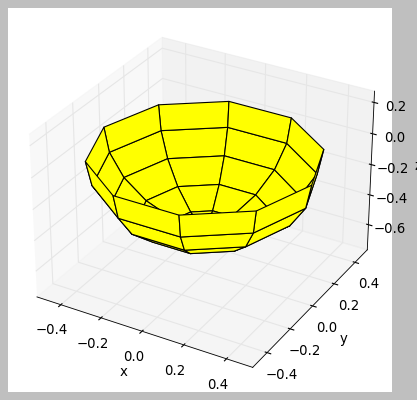

In [27]:
body.show_matplotlib()

In [28]:
phi_inc.shape
faces_centers.shape
x,y,z = faces_centers[0],faces_centers[1],faces_centers[2]
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot


mesh = body.mesh
vertices = mesh.vertices
faces = mesh.faces




/Users/qe5106hi/miniconda3/envs/WEC_array/lib/python3.11/site-packages/numpy/lib/histograms.py:839: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/qe5106hi/miniconda3/envs/WEC_array/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


(array([ 4.,  4.,  6.,  4., 12.,  2.,  4.,  6.,  4.,  4.]),
 array([-4.37699081e-01, -3.50159265e-01, -2.62619449e-01, -1.75079633e-01,
        -8.75398163e-02,  5.55111512e-17,  8.75398163e-02,  1.75079633e-01,
         2.62619449e-01,  3.50159265e-01,  4.37699081e-01]),
 <BarContainer object of 10 artists>)

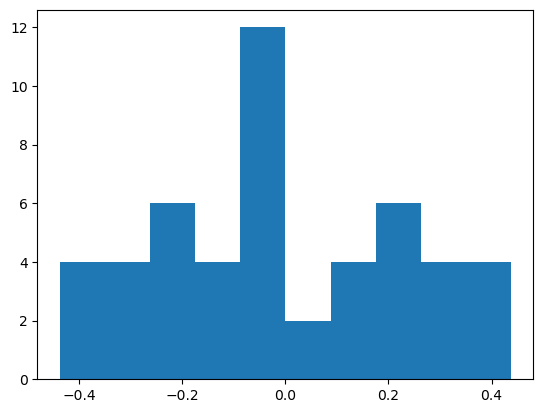

In [8]:
plt.hist(phi_inc)


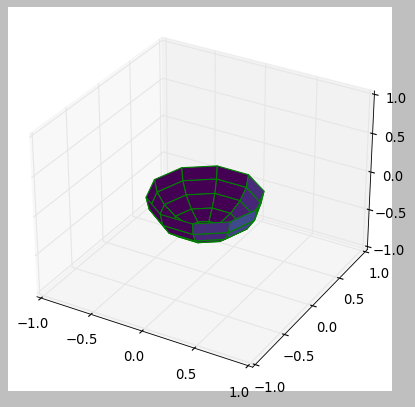

<Figure size 640x480 with 0 Axes>

In [29]:
from mpl_toolkits.mplot3d import Axes3D, art3d
plt.style.use('classic')
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
C1  = phi_inc.real
C2 = phi_inc.imag
norm1 = plt.Normalize(-4, 4)
norm2 = plt.Normalize(-4, 4)
colorsR = plt.cm.viridis(C1,1000)
colorsI = plt.cm.magma(C2,1000)
 
pc1 = art3d.Poly3DCollection(vertices[faces], facecolors=colorsR, edgecolor="green")
pc2 = art3d.Poly3DCollection(vertices[faces], facecolors=colorsI, edgecolor="green")
ax.axes.set_xlim3d(left=-1, right=1) 
ax.axes.set_ylim3d(bottom=-1, top=1) 
ax.axes.set_zlim3d(bottom=-1, top=1) 
ax.add_collection(pc1)
plt.show()
ax.add_collection(pc2)
plt.show()

plt.savefig('sphere.png')


B) Contributions due to wave interaction
1) Since we know the source distribution on an arbitrary body i from step 1, the potential at the mean center position of all other bodies 
 (
) due to sources on body i is computed by solving (9); this is denoted by ϕij. 

2) The total effect at body j is taken as the sum of the effects from all other bodies in terms of incident plane waves of complex amplitude ϕij, 

$$\phi_{j} = \sum \phi_{ij}e^{kz}e^{ik(x-x_j)cos\theta_{ij} + (y-y_j)sin\theta_{ij}$$


In [14]:
#potential at the mean center of a floating body
mean_point = np.mean(faces_centers,axis  = 0)
#find the potential for this average point

array([-1.66533454e-17,  8.88178420e-18, -3.13047835e-01])

In [40]:
#calculate angle theta_ij from centre of one body to other
def theta_ij(X,Y): 
    x1,y1= X[0],X[1]
    x2,y2 = Y[0], Y[1]
    if x2==x1:
        theta = np.pi/2
    else:
        theta = np.arctan((y2-y1)/(x2-x1))
    return theta
theta_ij([1,2,0],[1,3,0])

1.5707963267948966

In [41]:
def phi_j(phi_ij,theta,x,y,xj,yj,z):
    res = np.sum(phi_ij *np.exp(k*z)*np.exp(np.imag*k*(x-xj)*np.cos(theta) + (y-yj)*np.sin(theta)))
    return res

# get the mean point for all the following bodies
# get the potential on mesh(mean potential?)
# get the contribution using phi_ij
# Check for convergence. 
At each iteration, steps 1 and 2 contribute to the total potential on the body surface. This process is repeated until either the amplitude of the incident waves 
 becomes smaller than 10−2 for all bodies, or the maximum number of iterations is reached. This maximum is set to twice the number of bodies in the array. A shortcoming of the approach is that there may be resonance effects for some frequencies, resulting in non-convergence of the iterative procedure. This situation is handled by making a simple treatment that provide reasonably accurate results, namely that at any given iteration, if the amplitude 
 is larger than the previous two iterations, we stop including the interactions from body j on body i.

In [ ]:
tol = 0
max_iteration = 4 # 2 times the number of bodies
while tol<e-2 or iteration<max_iteration:
    amplitude = updated
    amplitude 
    
    